# Decision Tree Classifier - Work From Home Employee Burnout Classification

This notebook implements a Decision Tree Classifier for binary classification of employee burnout risk.

**Evaluation Metrics:**
1. Accuracy
2. AUC Score
3. Precision
4. Recall
5. F1 Score
6. Matthews Correlation Coefficient (MCC)

## 1. Import Libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Dataset from Kaggle

In [53]:
# Load the UCI Student Performance Dataset
from ucimlrepo import fetch_ucirepo

print("Loading dataset from UCI ML Repository...")
# Fetch dataset
student_performance = fetch_ucirepo(id=320)

# Get data as pandas dataframes
X = student_performance.data.features
y = student_performance.data.targets

# Combine features and target
df = pd.concat([X, y], axis=1)
print(f"Dataset loaded successfully! Shape: {df.shape}")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

Loading dataset from UCI ML Repository...
Dataset loaded successfully! Shape: (649, 33)

First 5 rows:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows

## 3. Data Preprocessing

In [54]:
# Create a copy
df_processed = df.copy()

# Handle missing values
print("Handling missing values...")
df_processed = df_processed.dropna()
print(f"Shape after dropping NaN: {df_processed.shape}")

# Identify categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    if col != 'Burn_Rate':  # Keep target separate
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"Encoded {col}")

# Handle target variable
if 'Burn_Rate' in df_processed.columns:
    if df_processed['Burn_Rate'].dtype == 'object':
        target_le = LabelEncoder()
        df_processed['Burn_Rate'] = target_le.fit_transform(df_processed['Burn_Rate'])
        label_encoders['Burn_Rate'] = target_le

print("\nData preprocessing completed!")

Handling missing values...
Shape after dropping NaN: (649, 33)

Categorical columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Numerical columns: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Encoded school
Encoded sex
Encoded address
Encoded famsize
Encoded Pstatus
Encoded Mjob
Encoded Fjob
Encoded reason
Encoded guardian
Encoded schoolsup
Encoded famsup
Encoded paid
Encoded activities
Encoded nursery
Encoded higher
Encoded internet
Encoded romantic

Data preprocessing completed!


## 4. Prepare Features and Target

In [55]:
# Identify target column
target_col = 'Burn_Rate' if 'Burn_Rate' in df_processed.columns else df_processed.columns[-1]

# Separate features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nFeature names:")
print(X.columns.tolist())

Features shape: (649, 32)
Target shape: (649,)

Target distribution:
G3
11    104
10     97
13     82
12     72
14     63
15     49
16     36
8      35
9      35
17     29
18     15
0      15
7      10
6       3
19      2
1       1
5       1
Name: count, dtype: int64

Feature names:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']


## 5. Split Data

In [56]:
# Split data into training and testing sets (80-20 split)
# Note: Decision Tree doesn't require feature scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())

Training set size: 519
Testing set size: 130

Training target distribution:
G3
10    80
11    79
13    69
12    56
14    51
15    39
9     30
8     28
16    27
17    24
0     13
7      9
18     8
6      3
19     1
1      1
5      1
Name: count, dtype: int64


## 6. Train Decision Tree Classifier

In [57]:
# Create and train the Decision Tree Classifier
print("Training Decision Tree Classifier...")
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

print("✅ Model training completed!")
print(f"\nModel parameters:")
print(f"Max depth: 10")
print(f"Number of features: {dt_model.n_features_in_}")
print(f"Classes: {dt_model.classes_}")

Training Decision Tree Classifier...
✅ Model training completed!

Model parameters:
Max depth: 10
Number of features: 32
Classes: [ 0  1  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


## 7. Make Predictions

In [58]:
# Make predictions
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)

print("Predictions made on test set!")
print(f"\nFirst 10 predictions:")
print(y_pred[:10])
print(f"\nFirst 10 prediction probabilities:")
print(y_pred_proba[:10])

Predictions made on test set!

First 10 predictions:
[18 11 17 12 11 16 18 11 10 11]

First 10 prediction probabilities:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0

## 8. Calculate Evaluation Metrics

In [59]:
# Calculate all 6 evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', labels=dt_model.classes_)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
mcc = matthews_corrcoef(y_test, y_pred)

# Display metrics
print("="*60)
print("EVALUATION METRICS - DECISION TREE CLASSIFIER")
print("="*60)
print(f"\n1. Accuracy:          {accuracy:.4f}")
print(f"2. AUC Score:         {auc_score:.4f}")
print(f"3. Precision:         {precision:.4f}")
print(f"4. Recall:            {recall:.4f}")
print(f"5. F1 Score:          {f1:.4f}")
print(f"6. MCC Score:         {mcc:.4f}")
print("="*60)

# Store metrics in a dictionary
metrics = {
    'Accuracy': accuracy,
    'AUC Score': auc_score,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'MCC Score': mcc
}

# Display as DataFrame
metrics_df = pd.DataFrame(metrics, index=['Decision Tree']).T
print("\nMetrics Summary:")
print(metrics_df)

EVALUATION METRICS - DECISION TREE CLASSIFIER

1. Accuracy:          0.4231
2. AUC Score:         nan
3. Precision:         0.4532
4. Recall:            0.4231
5. F1 Score:          0.4257
6. MCC Score:         0.3596

Metrics Summary:
           Decision Tree
Accuracy        0.423077
AUC Score            NaN
Precision       0.453195
Recall          0.423077
F1 Score        0.425668
MCC Score       0.359645


## 9. Additional Evaluation

In [60]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 1  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  3  0  0  1  0  0  0  0  0  0  0  0]
 [ 1  1  0  1  2  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  2  5  8  1  0  0  0  0  0  0  0]
 [ 0  0  1  2  3 13  4  2  0  0  0  0  0  0]
 [ 0  0  0  0  1  3  6  4  2  0  0  0  0  0]
 [ 0  0  0  0  1  0  1  9  2  0  0  0  0  0]
 [ 0  0  0  0  1  0  2  4  2  2  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  1  4  1  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  3  5  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  1  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  5  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           7       0.00      0.00      0.00         1
           8       0.60      0.43      0.50         7
           9       0.20      0.20      0.20         5
          10       0.38      0.29      0.33        17
 

## 10. Feature Importance


Top 10 Important Features:
      Feature  Importance
31         G2    0.322814
30         G1    0.073018
10     reason    0.052296
24   freetime    0.051961
2         age    0.047820
29   absences    0.046130
25      goout    0.045249
27       Walc    0.034681
7        Fedu    0.029317
13  studytime    0.023016


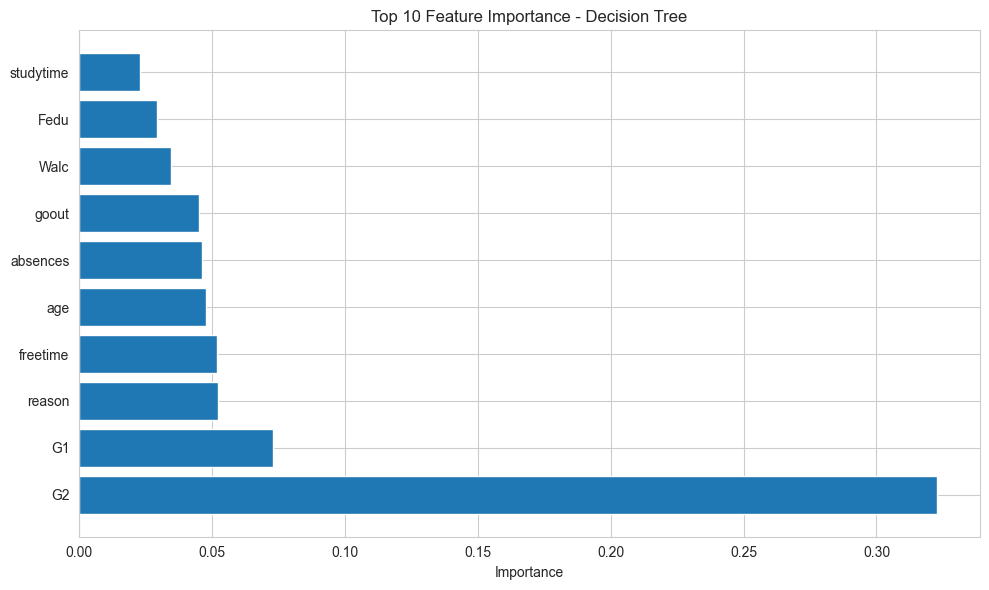

In [61]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance - Decision Tree')
plt.tight_layout()
plt.show()

## 11. Visualizations

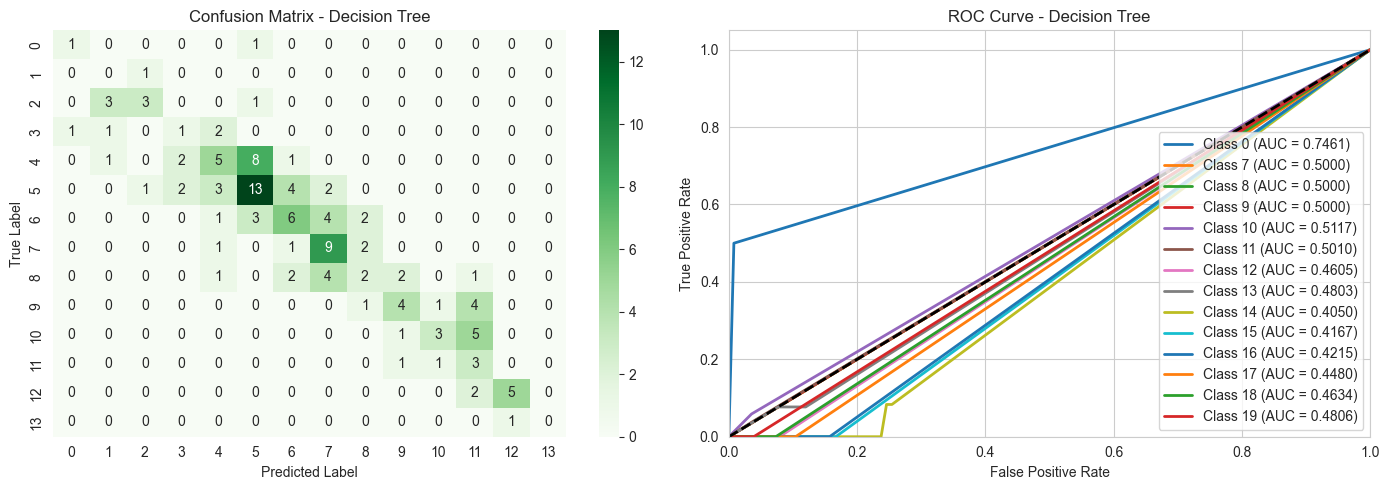


Visualizations complete!


In [62]:
# Plot Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title('Confusion Matrix - Decision Tree')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve - For multiclass, plot for each class
from sklearn.preprocessing import label_binarize
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.4f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Decision Tree')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

print("\nVisualizations complete!")

## 12. Model Summary

In [63]:
print("\n" + "="*60)
print("DECISION TREE CLASSIFIER MODEL SUMMARY")
print("="*60)
print(f"\nModel Type: Decision Tree Classifier")
print(f"Max Depth: 10")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")
print(f"Number of Features: {X_train.shape[1]}")
print(f"\nKey Metrics:")
print(f"  - Accuracy:  {accuracy:.4f}")
print(f"  - AUC Score: {auc_score:.4f}")
print(f"  - F1 Score:  {f1:.4f}")
print(f"\nModel Status: ✅ Training Complete")
print("="*60)


DECISION TREE CLASSIFIER MODEL SUMMARY

Model Type: Decision Tree Classifier
Max Depth: 10
Training Samples: 519
Testing Samples: 130
Number of Features: 32

Key Metrics:
  - Accuracy:  0.4231
  - AUC Score: nan
  - F1 Score:  0.4257

Model Status: ✅ Training Complete
